In [0]:
from keras import layers, models
import numpy as np
import numpy
import keras
import json
import os
from keras.preprocessing import image
from numpy import zeros
from numpy.random import randn
from matplotlib import pyplot
from time import gmtime, strftime

from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10

# Latent Dimension - Usually
# Value 100 is used
latent_dim = 100
# Cifar_10 image size
channels =3
height =32
width = 32

def generator():
    # Generator network
    generator_input = keras.Input(shape=(latent_dim, ))

    x = layers.Dense(512 * 8 * 8)(generator_input)
    x = layers.ReLU()(x)
    x = layers.Reshape((8,8,512))(x)

    x = layers.Conv2DTranspose(256, 3, strides = 2, padding='same')(x)  # 16*16*256
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.ReLU()(x)
    # Convolution 2D Transpose - deconvolution - upsampling
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x) # 32*32*256
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(channels, 5, activation='tanh', padding='same')(x) #sample 32*32*3 image
    generator = models.Model(generator_input, x)
    generator.summary()
    return generator

#generator.summary()

def discriminator():
    #discriminator network
    
    discriminator_input = layers.Input(shape=(height, width, channels))
    x = layers.Conv2D(64, 3, strides=1, padding='same')(descriminator_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.25)(x)

     x = layers.Conv2D(256, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(512, 3, strides=1, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    discriminator = models.Model(discriminator_input, x)
    discriminator.summary()
    return descriminator

generator = generator()
discriminator = discriminator()
# Optimizers
discriminator_optimizer = keras.optimizers.Adam(lr=0.0002,beta_1=0.5,beta_2=0.99)
generator_optimizer = keras.optimizers.Adam(lr=0.0004,beta_1=0.5,beta_2=0.99)

# Loss Functions - Binary Cross Entropy
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
generator.compile(optimizer=generator_optimizer, loss='binary_crossentropy')

discriminator.trainable = False

#gan
gan_input = layers.Input(shape=(latent_dim, ))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.Adam(lr=0.0004,beta_1=0.5,beta_2=0.99)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

#descriminator.trainable = True

#training the gan
# Loading cifar 10 dataset
(X_train, y_train), (_,_) =keras.datasets.cifar10.load_data()
X_train  = X_train[y_train.flatten() == 6]
X_train = X_train.reshape((X_train.shape[0], )+(height, width, channels)).astype('float32')/255.

# iterations and Batch Size
iterations = 100_000
batch_size = 32
# Directory name
save_dir = "./gan_generated_1"
start = 0

# To save Model - save the model architecture
# and save the weights
model_json = generator.to_json()
model_path = "/content/gdrive/My Drive/model_in_json.json"
with open(model_path, "w") as json_file:
    json.dump(model_json, json_file)

for step in range(iterations):
    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim)) #sample random points
    generated_images = generator.predict(random_latent_vectors) #output of the generator (decoded fake images)
    
    stop = start + batch_size
    real_images = X_train[start:stop]
    
    
    d_loss_real = descriminator.train_on_batch(real_images, np.ones((batch_size, 1))) #train the descriminator real

    d_loss_gen = descriminator.train_on_batch(generated_images, np.zeros((batch_size, 1))) #train the descriminator gen

    d_loss = 0.5 * np.add(d_loss_real, d_loss_gen)

    random_latent_vectors = np.random.normal(0,1, size = (batch_size, latent_dim))#sample random vectors
    fake_labels = np.ones((batch_size, 1)) #labels that lie that they are real images
    
    a_loss = gan.train_on_batch(random_latent_vectors, fake_labels) #train generator model via gan
    
    start += batch_size
    if start > len(X_train)-batch_size:
        start = 0
    # Prints discriminator loss and adversarial loss
    print(f"{step} descriminator loss {d_loss} adverserial loss {a_loss}")
    
    PATH = "/content/gdrive/My Drive/GAN_weight_2"
    if (step +1) %1000 ==0:
      name = 'generator_' + str(step+1) + '.h5'
      name = os.path.join(PATH,name)
      generator.save_weights(name)      

Using TensorFlow backend.













Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       1179904   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 16, 16, 256)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 descriminator loss 2.7639095783233643 adverserial loss 1.0129871368408203
1 descriminator loss 3.369981527328491 adverserial loss 3.2102365493774414


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2 descriminator loss 0.4646352231502533 adverserial loss 7.543071269989014
3 descriminator loss 2.195122718811035 adverserial loss 5.098453044891357
4 descriminator loss 1.0474402904510498 adverserial loss 7.157805442810059
5 descriminator loss 1.4813392162322998 adverserial loss 7.673686504364014
6 descriminator loss 1.3651951551437378 adverserial loss 4.508890628814697
7 descriminator loss 3.3320717811584473 adverserial loss 7.33487606048584
8 descriminator loss 1.528899908065796 adverserial loss 5.948336601257324
9 descriminator loss 2.734750270843506 adverserial loss 6.620949745178223
10 descriminator loss 1.5716134309768677 adverserial loss 4.444609642028809
11 descriminator loss 1.6382896900177002 adverserial loss 6.637243747711182
12 descriminator loss 1.157329797744751 adverserial loss 4.584290504455566
13 descriminator loss 2.0121965408325195 adverserial loss 9.561897277832031
14 descriminator loss 0.7688338160514832 adverserial loss 4.757533073425293
15 descriminator loss 0.6

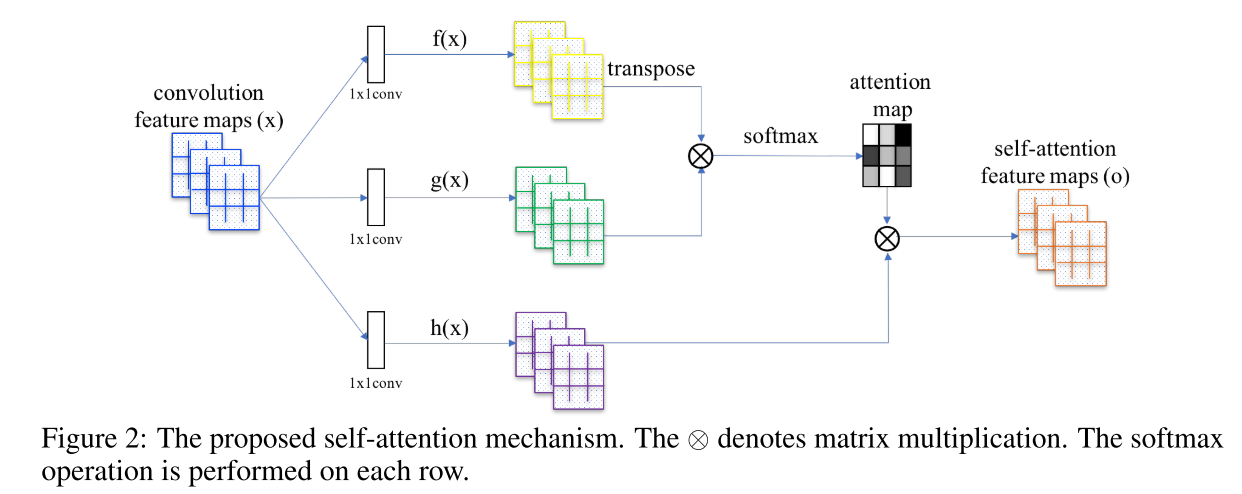

In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


## Lambda function and  Keras

```keras.layers.Lambda(function, output_shape=None, mask=None, arguments=None)```


In [3]:
from keras import backend as K
from keras.layers import Layer

class MyLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[0][1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        assert isinstance(x, list)
        a, b = x
        return [K.dot(a, self.kernel) + b, K.mean(b, axis=-1)]

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        shape_a, shape_b = input_shape
        return [(shape_a[0], self.output_dim), shape_b[:-1]]


In [4]:
import keras.backend as K
class SelfAttention(Layer):
    
    def __init__(self, filters):
        self.filters = filters
        super(Layer, self).__init__()
        
        self.f = Conv2D(filters,1,spectral_normalization=True, strides =1, padding='SAME', name='filter_f')
        
        self.g = Conv2D(filters, 1, spectral_normalization=True, strides =1, padding = 'SAME', name='filter_g')
        
        self.h = Conv2D(filters, 1, spectral_normalization=True, strides=1, padding='SAME',name ='filter_h')
        
        #self.gamma --> Hyperparameter
    
    def call(self, x):
        f = self.f(x)
        g = self.g(x)
        h = self.h(x)
        
        f_flatten = layers.Flatten()(f)
        g_flatten = layers.Flatten()(g)
        softmax_input = K.dot(g_flatten, K.transpose(f_flatten))
        
        softmax_output = keras.activations.softmax(softmax_input, axis=-1)
        
        h_flatten = layers.Flatten()(h)
        attention_map = K.dot(softmax_output, h_flatten)
        
        y = gamma * K.reshape(attention_map, K.shape(x)) + x
        
        
        return y


## Spectral Normalization

code taken from https://sthalles.github.io/advanced_gans/


In [5]:
def _l2normalizer(v, epsilon=1e-12):
    return v / (K.sum(v ** 2) ** 0.5 + epsilon)

def power_iteration(W, u, rounds=1):
    '''
    Accroding the paper, we only need to do power iteration one time.
    '''
    _u = u

    for i in range(rounds):
        _v = _l2normalizer(K.dot(_u, W))
        _u = _l2normalizer(K.dot(_v, K.transpose(W)))

    W_sn = K.sum(K.dot(_u, W) * _v)
    return W_sn, _u, _v

def compute_spectral_normal(self, training=True):
    # Spectrally Normalized Weight
    if self.spectral_normalization:
        # Get kernel tensor shape [batch, units]
        W_shape = self.kernel.shape.as_list()

        # Flatten the Tensor
        W_mat = K.reshape(self.kernel, [W_shape[-1], -1])  # [out_channels, N]

        W_sn, u, v = power_iteration(W_mat, self.u)

        if training:
            # Update estimated 1st singular vector
            self.u.assign(u)

        return self.kernel / W_sn
    else:
        return self.kernel